# Sprint 自然言語処理入門
## 1.このSprintについて
### Sprintの目的
自然言語処理の一連の流れを学ぶ
自然言語のベクトル化の方法を学ぶ
### どのように学ぶか
自然言語処理定番のデータセットを用いて、一連の流れを見ていきます。

## 2.自然言語のベクトル化
自然言語処理（NLP, Natural Language Processing） とは人間が普段使っている 自然言語 をコンピュータに処理させる技術のことです。  
ここではその中でも、機械学習の入力として自然言語を用いることを考えていきます。  

多くの機械学習手法は 数値データ（量的変数） の入力を前提にしていますので、自然言語の テキストデータ を数値データに変換する必要があります。  
これを 自然言語のベクトル化 と呼びます。ベクトル化の際にテキストデータの特徴をうまく捉えられるよう、様々な手法が考えられてきていますので、
このSprintではそれらを学びます。

3.IMDB映画レビューデータセットの準備
IMDB映画レビューデータセットを準備します。

ダウンロード
次のwgetコマンドによってダウンロードします。

In [1]:
# IMDBをカレントフォルダにダウンロード
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# 解凍
!tar zxf aclImdb_v1.tar.gz
# aclImdb/train/unsupはラベル無しのため削除
!rm -rf aclImdb/train/unsup
# IMDBデータセットの説明を表示
!cat aclImdb/README

--2020-03-26 11:19:45--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
ai.stanford.edu (ai.stanford.edu) をDNSに問いあわせています... 171.64.68.10
ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 84125825 (80M) [application/x-gzip]
`aclImdb_v1.tar.gz' に保存中

aclImdb_v1.tar.gz   100%[===================>]  80.23M  8.96MB/s 時間 10s        

2020-03-26 11:19:56 (7.74 MB/s) - `aclImdb_v1.tar.gz' へ保存完了 [84125825/84125825]

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unl

以下のサイトで公開されているデータセットです。

[リンクの練習](リンクのアドレス "リンクのタイトル")
[Sentiment Analysis](http://ai.stanford.edu/~amaas/data/sentiment/ "Sentiment Analysis")

`読み込み`  
scikit-learnのload_filesを用いて読み込みます。

[sklearn.datasets.load_files — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_files.html "sklearn.datasets.load_files — scikit-learn 0.21.3 documentation")

In [2]:
from sklearn.datasets import load_files

train_review = load_files('./aclImdb/train/', encoding='utf-8')
x_train, y_train = train_review.data, train_review.target

test_review = load_files('./aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target

# ラベルの0,1と意味の対応の表示
print(train_review.target_names)

['neg', 'pos']


In [3]:
len(x_train)

25000

In [4]:
# 今回は学習データを少なくして試してみる
import numpy as np
x_train_mini = x_train[:10000]
x_test_mini = x_test[:10000]
y_train_mini = np.array(y_train[:10000]).reshape(-1,)
y_test_mini = np.array(y_test[:10000]).reshape(-1,)
y_train_mini.shape

(10000,)

### このデータセットについて
中身を見てみると、英語の文章が入っていることが分かります。


In [5]:
print("x : {}".format(x_train_mini[0]))

x : Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.


IMDBはInternet Movie Databaseの略で、映画のデータベースサイトです。

[Ratings and Reviews for New Movies and TV Shows - IMDb](https://www.imdb.com "Ratings and Reviews for New Movies and TV Shows - IMDb")

このサイトではユーザーが映画に対して1から10点の評価とコメントを投稿することができます。そのデータベースから訓練用データは25000件、テスト用データは25000件のデータセットを作成しています。

4点以下を否定的、7点以下を肯定的なレビューとして2値のラベル付けしており、これにより感情の分類を行います。5,6点の中立的なレビューはデータセットに含んでいません。また、ラベルは訓練用・テスト用それぞれで均一に入っています。詳細はダウンロードしたREADMEを確認してください。  
  
## 4.古典的な手法
古典的ながら現在でも強力な手法であるBoWとTF-IDFを見ていきます。

## 5.BoW
単純ながら効果的な方法として BoW (Bag of Words) があります。  
これは、サンプルごとに単語などの 登場回数 を数えたものをベクトルとする方法です。単語をカテゴリとして捉え one-hot表現 していることになります。

### 例
例として、IMDBデータセットからある3文の最初の5単語を抜き出したものを用意しました。

In [6]:
mini_dataset = \
  ["This movie is very good.",
  "This film is a good",
  "Very bad. Very, very bad."]

この3文にBoWを適用させてみます。scikit-learnのCountVectorizerを利用します。

[sklearn.feature_extraction.text.CountVectorizer — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html "sklearn.feature_extraction.text.CountVectorizer — scikit-learn 0.21.3 documentation")

In [8]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
bow = (vectorizer.fit_transform(mini_dataset)).toarray()

# DataFrameにまとめる
df = pd.DataFrame(bow, columns=vectorizer.get_feature_names())
display(df)
# 実行すると次のような表が得られます。

,a,bad,film,good,is,movie,this,very
0,0,0,0,1,1,1,1,1
1,1,0,1,1,1,0,1,0
2,0,2,0,0,0,0,0,3


例にあげた3文の中で登場する8種類の単語が列名になり、0,1,2番目のサンプルでそれらが何回登場しているかを示しています。2番目のサンプル「Very bad. Very, very bad.」ではbadが2回、veryが3回登場しています。列名になっている言葉はデータセットが持つ 語彙 と呼びます。

テキストはBoWにより各サンプルが語彙数の次元を持つ特徴量となり、機械学習モデルへ入力できるようになります。この時使用したテキスト全体のことを コーパス と呼びます。語彙はコーパスに含まれる言葉よって決まり、それを特徴量としてモデルの学習を行います。そのため、テスト用データではじめて登場する語彙はベクトル化される際に無視されます。

### 前処理
CountVectorizerクラスでは大文字は小文字に揃えるという 前処理 が自動的に行われています。こういった前処理は自然言語処理において大切で、不要な記号などの消去（テキストクリーニング）や表記揺れの統一といったことを別途行うことが一般的です。

語形が「see」「saw」「seen」のように変化する単語に対して語幹に揃える ステミング と呼ばれる処理を行うこともあります。

### トークン
BoWは厳密には単語を数えているのではなく、 トークン（token） として定めた固まりを数えます。

何をトークンとするかはCountVectorizerでは引数token_patternで 正規表現 の記法により指定されます。デフォルトはr'(?u)\b\w\w+\b'ですが、上の例ではr'(?u)\b\w+\b'としています。

デフォルトでは空白・句読点・スラッシュなどに囲まれた2文字以上の文字を1つのトークンとして抜き出すようになっているため、「a」や「I」などがカウントされません。英語では1文字の単語は文章の特徴をあまり表さないため、除外されることもあります。しかし、上の例では1文字の単語もトークンとして抜き出すように引数を指定しています。

### 《正規表現》

正規表現は前処理の際にも活用しますが、ここでは詳細は扱いません。Pythonではreモジュールによって正規表現操作ができます。

[re — 正規表現操作](https://docs.python.org/ja/3/library/re.html "re — 正規表現操作")

正規表現を利用する際はリアルタイムで結果を確認できる以下のようなサービスが便利です。

[Online regex tester and debugger: PHP, PCRE, Python, Golang and JavaScript](https://regex101.com "Online regex tester and debugger: PHP, PCRE, Python, Golang and JavaScript")

### 形態素解析
英語などの多くの言語では空白という分かりやすい基準でトークン化が行えますが、日本語ではそれが行えません。

日本語では名詞や助詞、動詞のように異なる 品詞 で分けられる単位で 分かち書き することになります。例えば「私はプログラミングを学びます」という日本語の文は「私/は/プログラミング/を/学び/ます」という風になります。

これには MeCab や Janome のような形態素解析ツールを用います。Pythonから利用することも可能です。MeCabをウェブ上で簡単に利用できる  
[Web茶まめ](http://chamame.ninjal.ac.jp/ "Web茶まめ")
というサービスも国立国語研究所が提供しています。

自然言語では新しい言葉も日々生まれますので、それにどれだけ対応できるかも大切です。MeCab用の毎週更新される辞書として mecab-ipadic-NEologd がオープンソースで存在しています。

[mecab-ipadic-neologd/README.ja.md at master · neologd/mecab-ipadic-neologd](https://github.com/neologd/mecab-ipadic-neologd/blob/master/README.ja.md "mecab-ipadic-neologd/README.ja.md at master · neologd/mecab-ipadic-neologd")

n-gram
上のBoWの例では1つの単語（トークン）毎の登場回数を数えましたが、これでは語順は全く考慮されていません。

考慮するために、隣あう単語同士をまとめて扱う n-gram という考え方を適用することがあります。2つの単語をまとめる場合は 2-gram (bigram) と呼び、次のようになります。

In [9]:
# ngram_rangeで利用するn-gramの範囲を指定する
vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a good,bad very,film is,is a,is very,movie is,this film,this movie,very bad,very good,very very
0,0,0,0,0,1,1,0,1,0,1,0
1,1,0,1,1,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,2,0,1


2-gramにより「very good」と「very bad」が区別して数えられています。

単語をまとめない場合は 1-gram (unigram) と呼びます。
3つまとめる3-gram(trigram)など任意の数を考えることができます。1-gramと2-gramを組み合わせてBoWを行うといったこともあります。

## 【問題1】BoWのスクラッチ実装（BOWってのは文章の文字数をカウントする処理）
以下の3文のBoWを求められるプログラムをscikit-learnを使わずに作成してください。1-gramと2-gramで計算してください。

```
This movie is SOOOO funny!!!
What a movie! I never
best movie ever!!!!! this movie
```

In [10]:
mini_dataset2 = \
  ["This movie is SOOOO funny!!!",
  "What a movie! I never",
  "best movie ever!!!!! this movie"]

In [11]:
# 動作確認
# 1-gram
# ngram_rangeで利用するn-gramの範囲を指定する
vectorizer = CountVectorizer(ngram_range=(1, 1), token_pattern=r'(?u)\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset2)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a,best,ever,funny,i,is,movie,never,soooo,this,what
0,0,0,0,1,0,1,1,0,1,1,0
1,1,0,0,0,1,0,1,1,0,0,1
2,0,1,1,0,0,0,2,0,0,1,0


In [12]:
# 動作確認
# 2-gram
# ngram_rangeで利用するn-gramの範囲を指定する
vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset2)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a movie,best movie,ever this,i never,is soooo,movie ever,movie i,movie is,soooo funny,this movie,what a
0,0,0,0,0,1,0,0,1,1,1,0
1,1,0,0,1,0,0,1,0,0,0,1
2,0,1,1,0,0,1,0,0,0,1,0


In [13]:
# 1-gram
# ngram_rangeで利用するn-gramの範囲を指定する
vectorizer = CountVectorizer(ngram_range=(1, 1), token_pattern=r'(?u)\b\w+\b')
bow_train = (vectorizer.fit_transform(x_train)).toarray()
df1 = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
df1.head()

,0,00,000,0000000000001,00001,00015,000s,001,003830,006,...,état,étc,évery,êxtase,ís,ísnt,ø,østbye,über,üvegtigris
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# 2-gram
# ngram_rangeで利用するn-gramの範囲を指定する
vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b')
bow_train = (vectorizer.fit_transform(x_train)).toarray()
df2 = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
df2.head()

,0 0,0 00001,0 02,0 1,0 10,0 2,0 3,0 48,0 5,0 6,...,évery scene,êxtase ecstasy,ís brilliant,ísnt entertaining,østbye is,über alles,über annoying,über berlin,über spy,üvegtigris so
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### （１）1-gram

In [15]:
text_list = ['This movie is SOOOO funny!!!',
        'What a movie! I never',
        'best movie ever!!!!! this movie']

In [16]:
def BoW(text_list):
    word_list = [] #取り出した単語を入れる（重複あり）
    new_list = [] #小文字に変換した要素を入れる
    
    # リストを要素ごとに取り出す
    for line in text_list:
        a = line.lower()# 大文字を小文字に変換する
        new_list.append(a)

        # 空白区切りで，単語ごとに取り出す
        for word in a.split(' '):
            w = word.replace('!','')#!記号は消す
            word_list.append(w)

    key = set(word_list) #単語の重複を削除
    val = np.arange(len(key)) #単語のindexを辞書の値にする
    word_dict = dict(zip(key,val))#辞書にする
    
    bow_list = []#単語の出現回数を入れる

    for line in new_list:
        bow = [0] * len(word_dict)# 数えたい単語の個数分の０のリスト
        for word in line.split(' '):
            word = word.replace('!','')
            try:
                bow[word_dict[word]] += 1 # word_dictのkeyがwordなら１を足す
            except:
                pass
        bow_list.append(bow)

    col_name = []
    for name in word_dict.keys():
        col_name.append(name)
    display(pd.DataFrame(bow_list,columns=col_name))
    
    return col_name,np.array(bow_list)

In [17]:
col_name,bow_list = BoW(text_list)

,i,what,ever,a,funny,movie,best,soooo,is,this,never
0,0,0,0,0,1,1,0,1,1,1,0
1,1,1,0,1,0,1,0,0,0,0,1
2,0,0,1,0,0,2,1,0,0,1,0


### （2）2-gram

In [18]:
new_list = [] #小文字に変換した要素を入れる
gram2_list = []
# リストを要素ごとに取り出す
for line in text_list:
    a = line.lower()# 大文字を小文字に変換する
    new_list.append(a)
    word = a.split(' ')# 空白区切りで，単語ごとに取り出す
    last_word = word[-1].replace('!','')
    print('last:',last_word)
    for i in range(len(word)):
        word1 = word[i].replace('!','')
        word2 = word[i+1].replace('!','')
        word_set = [word1,word2]
        gram2 = ' '.join(word_set)
        gram2_list.append(gram2)
        if word2 == last_word:
            break

print(gram2_list)

last: funny
last: never
last: movie
['this movie', 'movie is', 'is soooo', 'soooo funny', 'what a', 'a movie', 'movie i', 'i never', 'best movie']


#### メモ
last: funny  
last: never  
last: movie  
['this movie', 'movie is', 'is soooo', 'soooo funny', 'what a', 'a movie', 'movie i', 'i never', 'best movie']  
↑これだと，最後のサンプルは文章途中で'movie'が出てきてしまうので失敗

In [19]:
new_list = [] #小文字に変換した要素を入れる
gram2_list = []
# リストを要素ごとに取り出す
for line in text_list:
    a = line.lower()# 大文字を小文字に変換する
    new_list.append(a)
    word = a.split(' ')# 1リストの中を’’で区切りの要素にする
    stop_index = len(word)-1 #１リストの最後の文字のインデックス
    #print('stop:',stop_index)
    
    # １リストの要素数繰り返す
    for i in range(stop_index):
        word1 = word[i].replace('!','')
        word2 = word[i+1].replace('!','')
        word_set = [word1,word2]
        gram2 = ' '.join(word_set) #各単語の間に空白を入れてjoin
        #print(gram2)
        gram2_list.append(gram2)
        #print(gram2_list)
        # リストの最後の文字になったら，次のリストのループへ
        if i == stop_index:
            break

print(gram2_list)

['this movie', 'movie is', 'is soooo', 'soooo funny', 'what a', 'a movie', 'movie i', 'i never', 'best movie', 'movie ever', 'ever this', 'this movie']


In [20]:
# 辞書の値
gram2_index = np.arange(len(gram2_list)-1)
# 辞書にする
gram2_dict = dict(zip(gram2_list,gram2_index))
gram2_dict,gram2_index

({'this movie': 0,
  'movie is': 1,
  'is soooo': 2,
  'soooo funny': 3,
  'what a': 4,
  'a movie': 5,
  'movie i': 6,
  'i never': 7,
  'best movie': 8,
  'movie ever': 9,
  'ever this': 10},
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

In [21]:
gram2_bow_list = []

for line in new_list:#小文字に変換したサンプルリスト
    bow = [0] * len(gram2_dict)# 数えたいトークンの個数分の０のリスト
    word = line.split(' ')
    #print(word)
    stop_index = len(word)-1
    #print('stop:',stop_index)
    for i in range(stop_index):
        word1 = word[i].replace('!','')
        word2 = word[i+1].replace('!','')
        word_set = [word1,word2]
        gram2 = ' '.join(word_set)
        try:
            bow[gram2_dict[gram2]] += 1 # word_dictのword番目の個数を足していく
        except:
            pass
    gram2_bow_list.append(bow)

col_name = []
for name in gram2_dict.keys():
    col_name.append(name)

pd.DataFrame(gram2_bow_list,columns=col_name)

,this movie,movie is,is soooo,soooo funny,what a,a movie,movie i,i never,best movie,movie ever,ever this
0,1,1,1,1,0,0,0,0,0,0,0
1,0,0,0,0,1,1,1,1,0,0,0
2,1,0,0,0,0,0,0,0,1,1,1


### 6.TF-IDF
BoWの発展的手法として TF-IDF もよく使われます。これは Term Frequency (TF) と Inverse Document Frequency (IDF) という2つの指標の組み合わせです。
IDF
IDFはそのトークンがデータセット内で珍しいほど値が大きくなる指標です。

- TF : 単語の出現頻度
- IDF: その単語の稀少性．珍しいほど値が大きくなる指標 TermFrequency(TF)

サンプル数 
N をIMDB映画レビューデータセットの訓練用データに合わせ25000として、トークンが出現するサンプル数 df(t) を変化させたグラフを確認してみると、
次のようになります。

### IDF
IDFはそのトークンがデータセット内で珍しいほど値が大きくなる指標です。　
サンプル数NをIMDB映画レビューデータセットの訓練用データに合わせ25000として、トークンが出現するサンプル数df(t)を変化させたグラフを確認してみると、次のようになります。

In [22]:
import numpy as np
import matplotlib.pyplot as plt
n_samples = 25000
idf = np.log(n_samples/np.arange(1,n_samples))
plt.title("IDF")
plt.xlabel("df(t)")
plt.ylabel("IDF")
plt.plot(idf)
plt.show()

TF-IDFではこの数を出現回数に掛け合わせるので、珍しいトークンの登場に重み付けを行なっていることになります。

### ストップワード
あまりにも頻繁に登場するトークンは、値を小さくするだけでなく、取り除くという前処理を加えることもあります。
取り除くもののことを ストップワード と呼びます。既存のストップワード一覧を利用したり、しきい値によって求めたりします。

scikit-learnのCountVectorizerでは引数stop_wordsにリストで指定することで処理を行なってくれます。

In [23]:
# 動作確認用
vectorizer = CountVectorizer(stop_words=["is"], token_pattern=r'\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a,bad,film,good,movie,this,very
0,0,0,0,1,1,1,1
1,1,0,1,1,0,1,0
2,0,2,0,0,0,0,3


代表的な既存のストップワード一覧としては、 *NLTK*  という自然言語処理のライブラリのものがあげられます。
あるデータセットにおいては特別重要な意味を持つ単語が一覧に含まれている可能性もあるため、使用する際は中身を確認することが望ましいです。

In [24]:
# はじめて使う場合はストップワードをダウンロード
import nltk
#stop_words = nltk.download('stopwords')

from nltk.corpus import stopwords
stop_w = stopwords.words('english')
print("stop word : {}".format(stop_w)) # 'i', 'me', 'my', ...

stop word : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

逆に、登場回数が特に少ないトークンも取り除くことが多いです。
全てのトークンを用いるとベクトルの次元数が著しく大きくなってしまい計算コストが高まるためです。

scikit-learnのCountVectorizerでは引数max_featuresに最大の語彙数を指定することで処理を行なってくれます。
以下の例では出現数が多い順に5個でベクトル化しています。

In [25]:
# 動作確認
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', max_features = 5)
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
df.head()

,bad,good,is,this,very
0,0,1,1,1,1
1,0,1,1,1,0
2,2,0,0,0,3


## 【問題2】TF-IDFの計算
IMDB映画レビューデータセットをTF-IDFによりベクトル化してください。
NLTKのストップワードを利用し、最大の語彙数は5000程度に設定してください。テキストクリーニングやステミングなどの前処理はこの問題では要求しません。

TF-IDFの計算にはscikit-learnの以下のどちらかのクラスを使用してください。

In [26]:
from  sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=stop_w,
                             ngram_range=(1,1),
                             max_features=5000,
                             token_pattern=r'(?u)\b\w\w+\b')

# tf-idfに基づいた分散表現になったベクトルが出てくる
x_train_v = (vectorizer.fit_transform(x_train_mini)).toarray()
train_feature = vectorizer.get_feature_names()#trainの特徴量をとってくる

# トレインのトークンに合わせる！vocabrary
vectorizer.vocabulary = train_feature

x_test_v = (vectorizer.fit_transform(x_test_mini)).toarray()
#vectorizer = TfidfVectorizer(min_df=0.03)

In [27]:
x_train_mini[0]

"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."

In [28]:
x_train_v[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
# テスト動作確認
corpus = [
'This is the first document.',
'This document is the second document.',
'And this is the third one.',
'Is this the first document?',
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df)
print(vectorizer.get_feature_names())
print(X.shape)
print(type(X))
type(X)
print(type(corpus))
print(type(df))
print(type(df.values))

['bad', 'good', 'is', 'this', 'very']
(5, 5)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'list'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [31]:
# 実データ
vectorizer = CountVectorizer(stop_words=stop_w, ngram_range=(1, 1), token_pattern=r'\b\w+\b', max_features = 5000)
bow_train = (vectorizer.fit_transform(x_train)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
df.head()

,0,00,000,1,10,100,11,12,13,13th,...,york,young,younger,youth,z,zero,zizek,zombie,zombies,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# 実データ、ベクトル化されているはずなんだがどうやってそのベクトル情報を見れるのだろうか？？
vectorizer = TfidfVectorizer(stop_words=stop_w, ngram_range=(1, 1), token_pattern=r'\b\w+\b', max_features = 5000)
# X = vectorizer.fit_transform(df)
X = vectorizer.fit_transform(x_train[0:1])
print(vectorizer.get_feature_names())
# print(X.shape)
# print(vectorizer.get_params())
X.toarray()

['actions', 'actors', 'almost', 'anything', 'better', 'beyond', 'bizarre', 'boys', 'br', 'captures', 'civility', 'classmates', 'commit', 'common', 'coupled', 'day', 'decided', 'define', 'destruction', 'elephant', 'even', 'explaining', 'far', 'film', 'filmmaker', 'flawed', 'gets', 'given', 'honest', 'honesty', 'humans', 'leads', 'likely', 'men', 'mode', 'money', 'motives', 'movie', 'murderers', 'must', 'mutual', 'order', 'perfect', 'product', 'rationalistic', 'remarkable', 'see', 'skin', 'slaughtering', 'suicide', 'terms', 'terrible', 'think', 'time', 'two', 'via', 'withdraw', 'world', 'would', 'young', 'zero']


array([[0.0949158, 0.0949158, 0.0949158, 0.0949158, 0.1898316, 0.0949158,
        0.0949158, 0.0949158, 0.3796632, 0.0949158, 0.0949158, 0.0949158,
        0.0949158, 0.0949158, 0.0949158, 0.0949158, 0.0949158, 0.0949158,
        0.0949158, 0.0949158, 0.0949158, 0.0949158, 0.1898316, 0.1898316,
        0.0949158, 0.0949158, 0.0949158, 0.0949158, 0.0949158, 0.0949158,
        0.0949158, 0.0949158, 0.0949158, 0.0949158, 0.0949158, 0.0949158,
        0.0949158, 0.0949158, 0.0949158, 0.0949158, 0.1898316, 0.0949158,
        0.0949158, 0.0949158, 0.0949158, 0.0949158, 0.0949158, 0.0949158,
        0.0949158, 0.1898316, 0.1898316, 0.0949158, 0.1898316, 0.0949158,
        0.2847474, 0.1898316, 0.0949158, 0.0949158, 0.0949158, 0.1898316,
        0.0949158]])

## 【問題3】TF-IDFを用いた学習
問題2で求めたベクトルを用いてIMDB映画レビューデータセットの学習・推定を行なってください。  
モデルは2値分類が行える任意のものを利用してください。

ここでは精度の高さは求めませんが、最大の語彙数やストップワード、n-gramの数を変化させて影響を検証してみてください。

In [33]:
from sklearn.preprocessing import StandardScaler # 標準化

from sklearn.metrics import accuracy_score # 正解率
from sklearn.metrics import precision_score # 適合率
from sklearn.metrics import recall_score # 再現率
from sklearn.metrics import f1_score # F値
from sklearn.metrics import confusion_matrix # 混合行列

from sklearn.linear_model import LogisticRegression # ロジスティック回帰

In [34]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

kfold = StratifiedKFold(n_splits=10,random_state=0).split(x_train_v,y_train_mini)
clf = SVC(gamma='auto')

# スコア確認
scores = cross_val_score(estimator=clf,X=x_test_v,y=y_test_mini,n_jobs=-1,scoring='accuracy',cv=3)
scores

array([0.50089982, 0.50105011, 0.50105011])

### 【問題4】TF-IDFのスクラッチ実装
以下の3文のTF-IDFを求められるプログラムをscikit-learnを使わずに作成してください。標準的な式と、scikit-learnの採用している式の2種類を作成してください。正規化は不要です。
- This movie is SOOOO funny!!!
- What a movie! I never
- best movie ever!!!!! this movie

In [35]:
text_list = ['This movie is SOOOO funny!!!',
             'What a movie! I never',
             'best movie ever!!!!! this movie']

In [36]:
col_name,bow_list = BoW(text_list)
n_sample,n_token = bow_list.shape

,i,what,ever,a,funny,movie,best,soooo,is,this,never
0,0,0,0,0,1,1,0,1,1,1,0
1,1,1,0,1,0,1,0,0,0,0,1
2,0,0,1,0,0,2,1,0,0,1,0


### （１）標準的なTF-IDF
TF：サンプル内でのトークンの出現回数
$tf(t,d)=\frac{n_{t,d}}{\sum_{s\ni d}n_{s,d}}$　　shape=(n_sample,ntoken)
$n&lt;/em&gt;{t,d}$ : サンプルd内のトークンtの出現回数（BoWと同じ） $\sum_{s\ni d}n_s,d$ : サンプルdの全トークンの出現回数の和

In [37]:
tf = np.zeros((n_sample,n_token))
for s in range(n_sample):
    denom = np.sum(bow_list[s,:])
    for t in range(n_token):
        tf[s,t] = bow_list[s,t] / denom
tf

array([[0. , 0. , 0. , 0. , 0.2, 0.2, 0. , 0.2, 0.2, 0.2, 0. ],
       [0.2, 0.2, 0. , 0.2, 0. , 0.2, 0. , 0. , 0. , 0. , 0.2],
       [0. , 0. , 0.2, 0. , 0. , 0.4, 0.2, 0. , 0. , 0.2, 0. ]])

### IDF（そのトークンの珍しさ）
$idf(t)=log\frac{N}{df(t)}$　　shape=(n_token)
$N$：サンプル数
$df(t)$：トークンtが出現するサンプル数　
※サンプル数が分子なので，出現回数の少ないほどトークンほど値が大きくなり，多いトークンほど１に近づく

In [38]:
dft = np.sum(bow_list,axis=0)
idf = np.log(n_sample/dft)
idf

array([ 1.09861229,  1.09861229,  1.09861229,  1.09861229,  1.09861229,
       -0.28768207,  1.09861229,  1.09861229,  1.09861229,  0.40546511,
        1.09861229])

### TF-IDF トークンの珍しさを加味した単語のベクトル化
$tfidf(t,d)=tf(t,d)*idf(t)$

In [39]:
tfidf = tf*idf
tfidf

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.21972246,
        -0.05753641,  0.        ,  0.21972246,  0.21972246,  0.08109302,
         0.        ],
       [ 0.21972246,  0.21972246,  0.        ,  0.21972246,  0.        ,
        -0.05753641,  0.        ,  0.        ,  0.        ,  0.        ,
         0.21972246],
       [ 0.        ,  0.        ,  0.21972246,  0.        ,  0.        ,
        -0.11507283,  0.21972246,  0.        ,  0.        ,  0.08109302,
         0.        ]])

### sklearnでのTFとIDFの式
TF
$tf(t,d)=n_{t,d}$

In [40]:
tf_sk = bow_list
tf_sk

array([[0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0],
       [1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 2, 1, 0, 0, 1, 0]])

### IDF
$idf(t)=log\frac{1+N}{1+df(t)}+1$

In [41]:
dft_sk = np.sum(bow_list,axis=0)
idf_sk = 1 + (np.log((1 + n_sample)/(1 + dft_sk)))
idf_sk

array([1.69314718, 1.69314718, 1.69314718, 1.69314718, 1.69314718,
       0.77685645, 1.69314718, 1.69314718, 1.69314718, 1.28768207,
       1.69314718])

### TF-IDF

In [42]:
tfidf_sk = tf_sk*idf_sk
tfidf_sk

array([[0.        , 0.        , 0.        , 0.        , 1.69314718,
        0.77685645, 0.        , 1.69314718, 1.69314718, 1.28768207,
        0.        ],
       [1.69314718, 1.69314718, 0.        , 1.69314718, 0.        ,
        0.77685645, 0.        , 0.        , 0.        , 0.        ,
        1.69314718],
       [0.        , 0.        , 1.69314718, 0.        , 0.        ,
        1.5537129 , 1.69314718, 0.        , 0.        , 1.28768207,
        0.        ]])

### 7.Word2Vec
ニューラルネットワークを用いてベクトル化を行う手法が Word2Vec です。

BoWやTF-IDFはone-hot表現であったため、得られるベクトルの次元は語彙数分になります。そのため、語彙数を増やしにくいという問題があります。一方で、Word2Vecでは単語を任意の次元のベクトルに変換します。これをを Word Embedding（単語埋め込み） や 分散表現 と呼びます。変換操作を「ベクトル空間に埋め込む」と言うことが多いです。

Word2VecにはCBoWとSkip-gramという2種類の仕組みがあるため順番に見ていきます。

### CBoW
CBoW (Continuous Bag-of-Words) によるWord2Vecではある単語とある単語の間に来る単語を推定できるように全結合層2層のニューラルネットワークを学習します。

単語はコーパスの語彙数次元のone-hot表現を行なっておきます。そのため、入力と出力の次元は語彙数と同じになります。一方で、中間のノード数をWord2Vecにより得たい任意の次元数とします。これにより全結合層の重みは「得たい次元のノード数×語彙数」になります。このネットワークにより学習を行なった後、出力側の重みを取り出すことで、各語彙を表すベクトルを手に入れることができます。

間の単語の推定を行なっているため、同じ箇所で代替可能な言葉は似たベクトルになるというメリットもあります。これはBoWやTF-IDFでは得られない情報です。

あるテキストは「そのテキストの長さ（単語数）×Word2Vecで得た分散表現の次元数」の配列になりますが、各入力の配列を揃える必要があるモデルに入力するためには、短いテキストは空白を表す単語を加える パディング を行なったり、長いテキストは単語を消したりします。テキストを 固定長 にすると呼びます。

### ウィンドウサイズ
入力する単語は推定する前後1つずつだけでなく、複数個とする場合もあります。前後いくつを見るかの大きさを ウィンドウサイズ と呼びます。

### Skip-gram
CBoWとは逆にある単語の前後の単語を推定できるように全結合層2層のニューラルネットワークを学習する方法が Skip-gram です。学習を行なった後は入力側の重みを取り出し各語彙を表すベクトルとします。現在一般的に使われているのはCBoWよりもSki-gramです。

### 利用方法
Pythonでは Gensim ライブラリを用いて扱うことができます。

gensim: models.word2vec – Word2vec embeddings

BoWの例と同じ文章で学習してみます。CountVectorizerと異なり前処理を自動的に行なってはくれないため、単語（トークン）はリストで分割しておきます。また、大文字は小文字に揃え、記号は取り除きます。

デフォルトのパラメータではCBoWで計算されます。また、ウィンドウサイズはwindow=5に設定されています。

In [43]:
from gensim.models import Word2Vec
sentences = [['this', 'movie', 'is', 'very', 'good'], ['this', 'film', 'is', 'a', 'good'], ['very', 'bad', 'very', 'very', 'bad']]
model = Word2Vec(min_count=1, size=10) # 次元数を10に設定（設定した次元数が1単語の新たな特徴数になる）
model.build_vocab(sentences) # 準備
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter) # 学習

print("語彙の一覧 : {}".format(model.wv.vocab.keys()))

for vocab in model.wv.vocab.keys():
    print("{}のベクトル : \n{}".format(vocab, model.wv[vocab]))

語彙の一覧 : dict_keys(['this', 'movie', 'is', 'very', 'good', 'film', 'a', 'bad'])
thisのベクトル : 
[ 0.03982401 -0.03354793  0.03517673  0.03938588  0.04113509  0.01928497
 -0.03263237  0.00462569 -0.00520296 -0.03797516]
movieのベクトル : 
[ 0.03353331 -0.00096623 -0.02000885 -0.03608076  0.01896216 -0.01869285
 -0.04259938 -0.01530885 -0.01986516 -0.04255993]
isのベクトル : 
[ 0.01071955 -0.04134709 -0.01198647 -0.02462669  0.00684498 -0.00545132
  0.01025507 -0.03216337 -0.01200509 -0.0450364 ]
veryのベクトル : 
[ 0.02808396 -0.00606047  0.02804701 -0.03264506  0.03240705  0.01311386
 -0.00491147 -0.01731167 -0.01636592  0.04886133]
goodのベクトル : 
[-0.00229544  0.02253328 -0.02166468  0.00623459  0.03329371  0.03109738
  0.03119473 -0.02941833 -0.0209693  -0.03991884]
filmのベクトル : 
[-0.00315033 -0.04729151  0.00545297  0.0170917  -0.04074387 -0.001722
 -0.00673409 -0.01647381  0.02199463 -0.01400164]
aのベクトル : 
[-0.02752648  0.01624399  0.00957163 -0.03938824  0.02394172  0.03189627
 -0.0362041  -0.04349204 

/Users/tominagashuuji/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


### 単語の距離
ベクトル間で計算を行うことで、ある単語に似たベクトルを持つ単語を見つけることができます。例えばgoodに似たベクトルの単語を3つ探します。

In [44]:
model.wv.most_similar(positive="good", topn=3)

[('is', 0.3915192186832428),
 ('a', 0.30356907844543457),
 ('movie', 0.1895611435174942)]

今の例では3文しか学習していませんので効果を発揮しませんが、大きなコーパスで学習することで、並列関係のものが近くに来たりなど面白い結果が得られます。

### 可視化
2次元に圧縮することで単語ごとの位置関係を可視化することができます。以下はt-SNEを用いた例です。

/Users/tominagashuuji/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


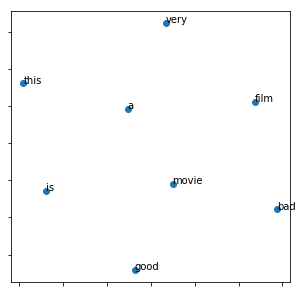

In [45]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

vocabs = model.wv.vocab.keys()

tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

## ４．IMDB映画レビューデータセットの分散表現
IMDB映画レビューデータセットの訓練データをコーパスとしてWord2Vecを学習させ分散表現を獲得しましょう。

### 【問題5】コーパスの前処理
コーパスの前処理として、特殊文字（!など）やURLの除去、大文字の小文字化といったことを行なってください。また、単語（トークン）はリストで分割してください。

In [46]:
from nltk.stem.porter import PorterStemmer #ステミング
import nltk.data
import re

In [47]:
def review_wordlist(review):
    """文章中の記号やURLを除去"""
    review_text = re.sub(r'<.*?>',' ',review)#htmlタグを消す
    review_text = re.sub(r'[^a-zA-Z]',' ',review_text)#文字でないもの（記号を消す）
    review_text = re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-…]+', '', review_text)#urlを消す
    ps = PorterStemmer()
    review = ps.stem(review_text)#ステミング ex)going→go，dogs→dog
    words = review_text.lower().split()#小文字に変換，' 'で区切る 
    stops = set(stopwords.words("english"))#stopwordの除去
    words = [w for w in words if not w in stops]
    # 返り値はリスト
    return (words)

In [48]:
clean_review = []
for i in x_train_mini:
    clean = review_wordlist(i)
    clean_review.append(clean)

In [49]:
clean_review[0]

['zero',
 'day',
 'leads',
 'think',
 'even',
 'think',
 'two',
 'boys',
 'young',
 'men',
 'would',
 'commit',
 'mutual',
 'suicide',
 'via',
 'slaughtering',
 'classmates',
 'captures',
 'must',
 'beyond',
 'bizarre',
 'mode',
 'two',
 'humans',
 'decided',
 'withdraw',
 'common',
 'civility',
 'order',
 'define',
 'mutual',
 'world',
 'via',
 'coupled',
 'destruction',
 'perfect',
 'movie',
 'given',
 'money',
 'time',
 'filmmaker',
 'actors',
 'remarkable',
 'product',
 'terms',
 'explaining',
 'motives',
 'actions',
 'two',
 'young',
 'suicide',
 'murderers',
 'better',
 'elephant',
 'terms',
 'film',
 'gets',
 'rationalistic',
 'skin',
 'far',
 'far',
 'better',
 'film',
 'almost',
 'anything',
 'likely',
 'see',
 'flawed',
 'honest',
 'terrible',
 'honesty']

### 【問題6】Word2Vecの学習
Word2Vecの学習を行なってください。

### （アドバンス課題）【問題7】ベクトルの可視化
得られたベクトルをt-SNEにより可視化してください。また、いくつかの単語を選びwv.most_similarを用いて似ている単語を調べてください。

#### 学習済みベクトル
巨大なコーパスで学習して得たベクトルも公開されているため、自分で学習をせずに利用することもできます。オリジナルのWord2Vecの他に同じ作者の発展系である FastText やスタンフォード大の GloVe があり、それぞれ公開されています。

In [50]:
num_features = 100  # ワードベクトルの次元
min_word_count = 40 # 単語数
context = 10        # ウィンドウサイズ
downsampling = 1e-3 # (0.001)頻出後のダウンサンプリング

model = Word2Vec(size=num_features,
                 min_count=min_word_count,
                 window=context,
                 sample=downsampling)

model.build_vocab(clean_review) # 準備
model.train(clean_review, total_examples=model.corpus_count, epochs=model.iter) # 学習

/Users/tominagashuuji/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  if sys.path[0] == '':


(4491655, 6003635)

#### goodに似ている単語

In [51]:
model.wv.most_similar(positive="good", topn=10)

[('nice', 0.7670329809188843),
 ('great', 0.7286198139190674),
 ('pretty', 0.6971200704574585),
 ('ok', 0.6887023448944092),
 ('awesome', 0.683603048324585),
 ('really', 0.678135335445404),
 ('decent', 0.6654657125473022),
 ('rest', 0.6345735192298889),
 ('okay', 0.6342771649360657),
 ('average', 0.6336303353309631)]

なぜかreally．．．niceやok，greatはいい感じ

### 可視化
t-sneとは，次元削減手法のひとつで，PCAとは違って，非線形にデータを圧縮できる．らしい．
高次元空間におけるデータ同士の「近さ（類似度）」が、低次元空間におけるデータ同士の「近さ」に反映されるよう学習を行う.
「近さ」の指標としてはユークリッド距離やコサイン類似度など様々なものがありますが、 SNE の大きな特徴として，この「近さ」を確率分布によって表現することが挙げらる

- n_components : 圧縮したい次元数
- init : 次元削減手法の初期化．randomよりpcaの方が安定するらしい
- n_iter : 最適化の最大反復回数。250以上である必要がある


In [52]:
vocabs = model.wv.vocab.keys()#word2vecでベクトル化した単語
#t-SNEをインスタンス化
tsne_model = TSNE(n_components=2,perplexity=40,init="pca", n_iter=5000, random_state=23)
#2次元まで圧縮
vectors_tsne = tsne_model.fit_transform(model[vocabs])

/Users/tominagashuuji/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [53]:
vectors_tsne

array([[-47.081852 ,   6.3768373],
       [ 12.987672 , -51.095688 ],
       [ 40.153183 ,  48.808113 ],
       ...,
       [  5.939926 ,  13.596063 ],
       [ 27.176865 ,  38.879128 ],
       [ -9.3296   , -31.368578 ]], dtype=float32)

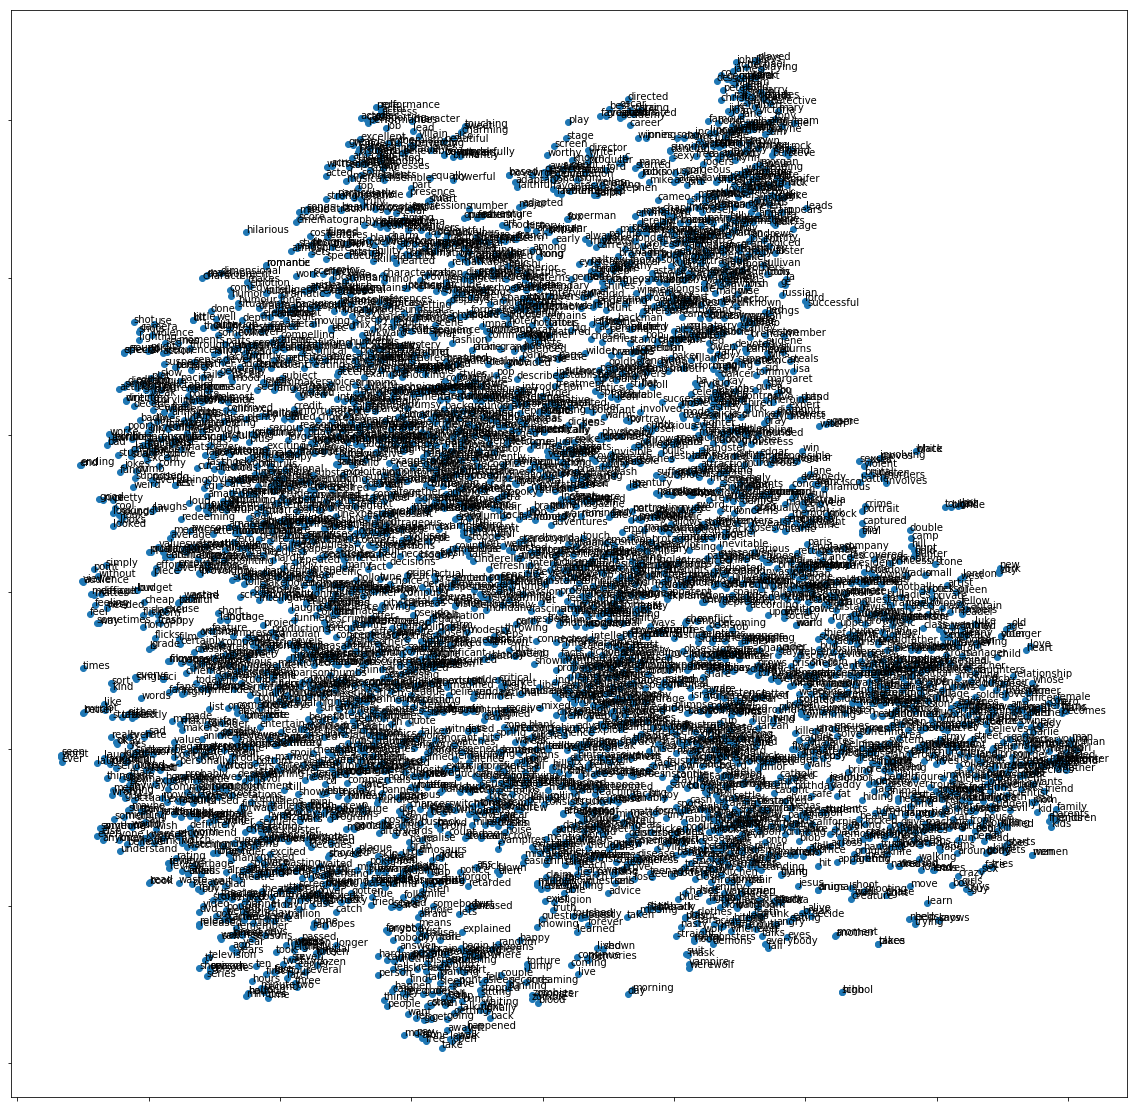

In [54]:
#可視化
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

多すぎて見づらいので，単語数を50まで減らして可視化する

In [55]:
mini_vocabs = list(vocabs)[:100]

In [56]:
vectors_tsne_mini = tsne_model.fit_transform(model[mini_vocabs])

/Users/tominagashuuji/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


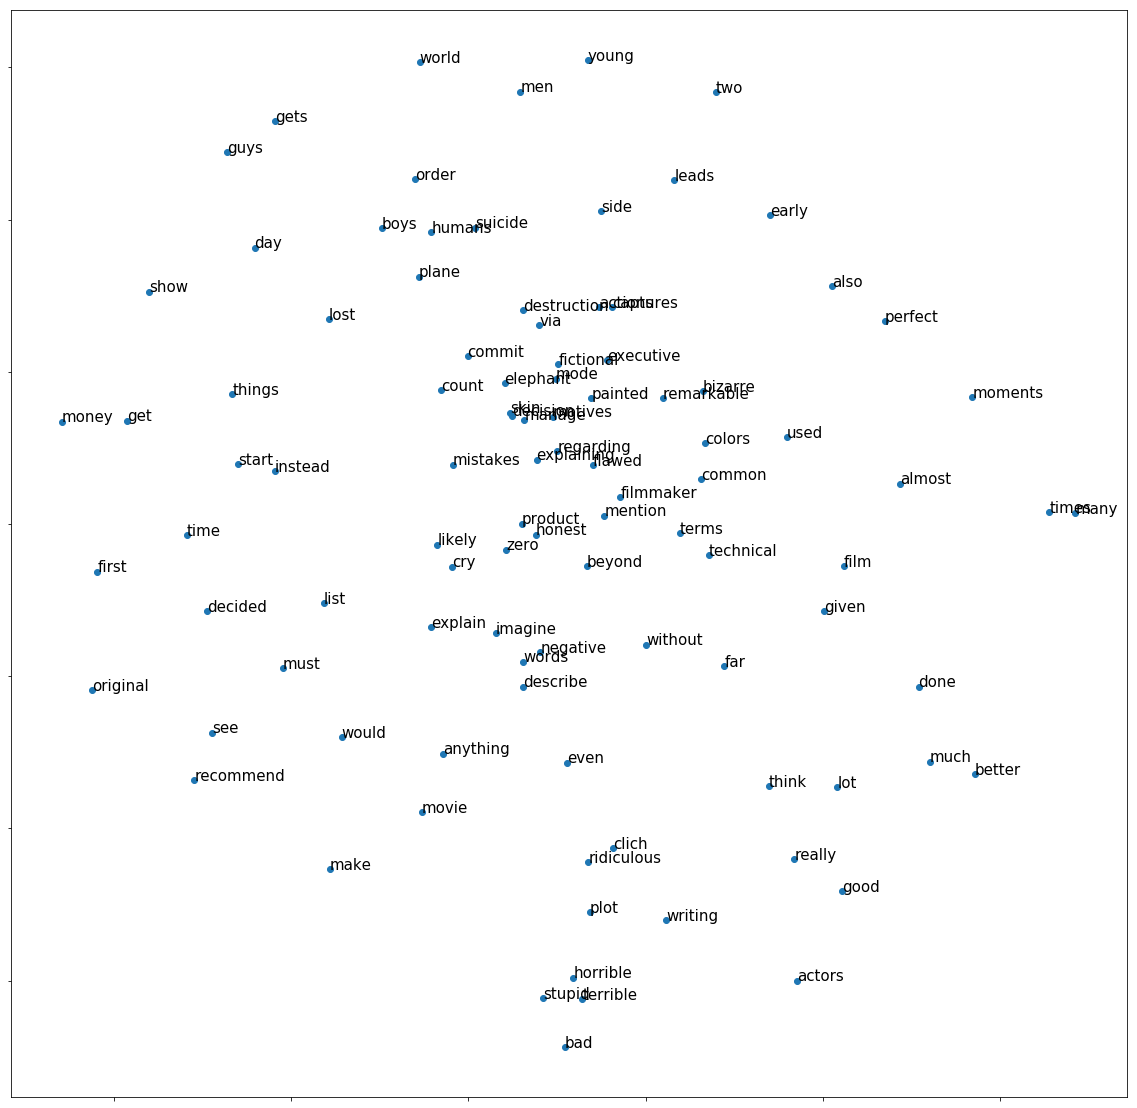

In [57]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(vectors_tsne_mini[:, 0], vectors_tsne_mini[:, 1])
for i, word in enumerate(mini_vocabs):
    plt.annotate(word, xy=(vectors_tsne_mini[i, 0], vectors_tsne_mini[i, 1]),fontsize=15)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()
